# Calculate statistics for functional data attributes

Calculate statistical data, such as mean tensile response curves and confidence intervals, from functional data attributes in test records. Import the roll-up data into Granta MI.

## Get test data from Granta MI

Connect to Granta MI and specify a database and tables.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mpy

s = mpy.Session('localhost', autologon=True)
db = s.get_db('MI Training')
test_table = db.get_table('Tensile Test Data')
statistics_table = db.get_table('Tensile Statistical Data')

Records in these tables are organised by test temperature, so we can fetch all the temperature folders in *Tensile Test Data* and their children. 

Use `table.bulk_fetch()` to efficiently populate the attributes for each test record.

In [2]:
material_record = test_table.search_for_records_by_name('Plate')[0]

temperature_records = {round(rec.children[0].attributes['Test Temperature'].value, 1): rec
                       for rec in material_record.children}
test_records = [temperature.children for temperature in temperature_records.values()]

test_table.bulk_fetch([test for tests in test_records for test in tests],
                      [test_table.attributes['Tensile Response (11 axis)'],
                       test_table.attributes['Specimen ID'],
                       test_table.attributes['Test Temperature']])
temperature_unit = test_table.attributes['Test Temperature'].unit

Create a `pandas` DataFrame and populate it with data from the functional attribute *Tensile Response (11 axis)*, as well as *Specimen ID* and *Test Temperature*. 

To produce a usable DataFrame, the functional data must:

1. Have the headers removed
2. Be converted from a range into a single value

In [3]:
import pandas as pd
df_response = pd.DataFrame()
for group in test_records:
    for record in group:
        response_attr = record.attributes['Tensile Response (11 axis)']
        specimen_id = record.attributes['Specimen ID'].value
        test_temperature = record.attributes['Test Temperature'].value

        df_functional_data = pd.DataFrame(response_attr.value[1:], columns=response_attr.value[0])

        df_current = pd.concat([
            df_functional_data['Strain [% strain]'],
            df_functional_data[['Y min (Tensile Response (11 axis) [MPa])',
                                'Y max (Tensile Response (11 axis) [MPa])']]
                .mean(axis=1)
                .rename('Tensile Response (11 axis) [MPa]')],
            axis=1)
        df_current['Specimen ID'] = specimen_id
        df_current['Test Temperature [{0}]'.format(temperature_unit)] = round(test_temperature, 1)
        df_response = pd.concat([df_response, df_current])

## Process the data and calculate statistics

For easier plotting, interpolate each series onto the union of all the parameter values (`pandas` uses the strain parameter as an index for the union). Any `NaN` inside the populated area for this column is interpolated by the `interpolate()` method with `limit_area='inside'`.

Group the data by *Test Temperature*, then use `scipy` to calculate the 95% confidence intervals by passing the count, mean and standard deviation of the grouped data.

In [4]:
import scipy.stats as st
df_interpolated = df_response.pivot(index='Strain [% strain]',
                                    values='Tensile Response (11 axis) [MPa]',
                                    columns=['Specimen ID', 'Test Temperature [K]']) \
    .interpolate(method='index', limit_direction='both', limit_area='inside')

grouped_by = df_interpolated.groupby(level='Test Temperature [K]', axis=1)
confidence_intervals = st.t.interval(0.95, grouped_by.count(), loc=grouped_by.mean(), scale=grouped_by.std())

Convert the transformed data into an aggregate DataFrame for plotting and import, taking the minimum, maximum, confidence intervals and mean at each strain value and temperature.

In [5]:
df_all_plots = pd.DataFrame()

for temperature_index, temperature in enumerate(grouped_by.groups):
    # Convert the confidence intervals into a DataFrame
    df_cis = pd.DataFrame(data=zip(*[[row[temperature_index] for row in confidence_intervals[0]],
                                     [row[temperature_index] for row in confidence_intervals[1]]]),
                          index=df_interpolated.index).rename(columns={0: 'lower_ci', 1: 'upper_ci'})
    # Combine with the other derived quantities
    df_plot = pd.concat([grouped_by.mean()[temperature].rename('mean'),
                         grouped_by.min()[temperature].rename('min'),
                         grouped_by.max()[temperature].rename('max'),
                         df_cis], axis=1).dropna()
    # Polish up the DataFrame for aggregation
    df_plot['temperature'] = temperature
    df_plot = df_plot.rename_axis('strain')
    df_all_plots = pd.concat([df_all_plots, df_plot.reset_index()])

Plot the aggregated data using `matplotlib`, creating a grid of subplots with identical (shared) axes to easily compare the tensile response at different temperatures.

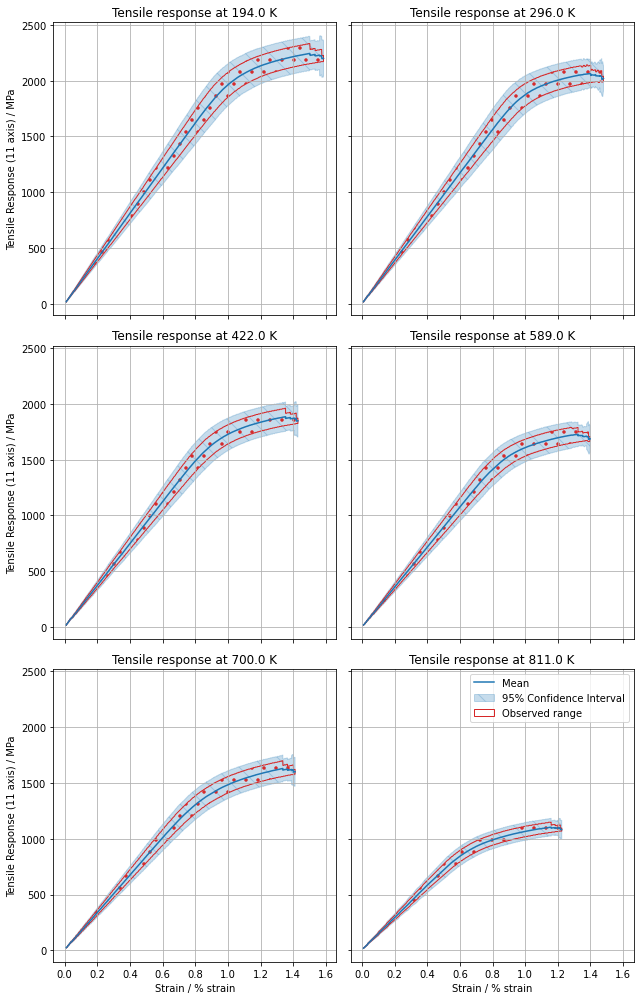

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 125

fig, axs = plt.subplots(3, 2, figsize=(9, 14), sharex='all', sharey='all')

for plot_index, temperature in enumerate(grouped_by.groups):
    ax = axs[plot_index // 2][plot_index % 2]

    # Get the rows corresponding to the current temperature
    df_plot = df_all_plots.loc[df_all_plots['temperature'] == temperature]

    ax.plot(df_plot['strain'], df_plot['mean'], label='Mean')
    ax.fill_between(df_plot['strain'],
                    df_plot['lower_ci'],
                    df_plot['upper_ci'],
                    label='95% Confidence Interval',
                    hatch='\\', facecolor='C0', edgecolor='C0', alpha=0.25)
    ax.fill_between(df_plot['strain'],
                    df_plot['min'],
                    df_plot['max'],
                    label='Observed range', hatch='.', facecolor='none', edgecolor='C3')

    ax.set_title("Tensile response at {0} {1}".format(round(temperature, 0), temperature_unit))
    ax.grid('major')

plt.setp(axs[-1, :], xlabel='Strain / % strain')
plt.setp(axs[:, 0], ylabel='Tensile Response (11 axis) / MPa')
plt.legend()
plt.tight_layout()
plt.show()

## Import roll-up data into Granta MI

Define two helper functions: one that resamples a DataFrame linearly based on a target column's values, and one that appends a series of range values to a `FloatFunctionalAttributeValue`, skipping any `NaN` values.

(Although `pandas` has a built-in `resample()` function, it only operates on time-series data.)

In [7]:
import numpy as np

def subsample_dataframe(df, x_axis, n_samples):
    new_index = np.linspace(df[x_axis].min(), df[x_axis].max(), n_samples)
    df.index = df[x_axis]
    df_subsampled = df.reindex(df.index.union(new_index)).interpolate('index').reindex(index=new_index)
    df_subsampled.index = range(n_samples)
    return df_subsampled

def append_series(functional_attribute, x_data, y_low_data, y_high_data=None, data_type=None):
    if y_high_data is None:
        y_high_data = y_low_data
    for x, y_low, y_high in zip(x_data, y_low_data, y_high_data):
        if pd.isna(y_low) or pd.isna(y_high):
            continue
        functional_attribute.value.append([y_low, y_high, x, data_type, False])

Import the roll-up data into Granta MI. Use `path_from()` to create a folder path with the new statistical data record at the end node, and populate the *Test Temperature* and *Tensile Response Analysis (11 axis)* attributes using the helper functions.

Write the new record to Granta MI using `Session.update()`, then link the newly-created attribute to the relevant test results. Finally, write the new links to Granta MI using `Session.update_links()`.

In [8]:
import datetime

t_statistics = db.get_table('Tensile Statistical Data')
timestamp = datetime.datetime.utcnow().isoformat()
for plot_index, temperature in enumerate(grouped_by.groups):
    # Create a record to store the imported data
    rec = t_statistics.path_from(starting_node=None, tree_path=['Data Analytics', timestamp],
                                 end_node='Functional Rollup ({0} {1})'.format(round(temperature, 0), temperature_unit),
                                 color='Olive')
    
    temp_attribute = rec.attributes['Test Temperature']
    temp_attribute.points = [temperature]
    temp_attribute.unit = temperature_unit

    func_attr = rec.attributes['Tensile Response Analysis (11 axis)']
    func_attr.unit = 'MPa'

    # Get the rows corresponding to the current temperature
    df_current = df_all_plots.loc[df_all_plots['temperature'] == temperature]

    df_current = subsample_dataframe(df_current, 'strain', 101)
    append_series(func_attr, df_current['strain'], df_current['mean'], data_type='Mean')
    append_series(func_attr, df_current['strain'], df_current['lower_ci'], df_current['upper_ci'], data_type='95% Confidence Interval')
    append_series(func_attr, df_current['strain'], df_current['min'], df_current['max'], data_type='Range')

    rec.set_attributes([temp_attribute, func_attr])
    rec = s.update([rec])[0]
    rec.set_links('Tensile Test Data', temperature_records[temperature].children)
    s.update_links([rec])
